In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from project.ranker.ranker import RankingPredictor

In [3]:
%%time
from sklearn.model_selection import train_test_split
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores = rp.named_steps['estimator'].get_data()

X, _, y, _, y_scores, _ = train_test_split(df_mf.values,
                                           df_rank.values,
                                           df_scores.values,
                                           test_size=0,
                                           random_state=42)
print(X.shape, y.shape, y_scores.shape)

(60, 39) (60, 13) (60, 13)
CPU times: user 39.4 s, sys: 3.63 s, total: 43.1 s
Wall time: 42.8 s


In [15]:
from project.ranker.ltr_rankers import wide2long
X_long, y_long = wide2long(X, y)
X_long.shape, y_long.shape

((780, 40), (780,))

In [32]:
from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X_long[:,:-1])
X_cat = X_long[:,-1].astype(int)

In [44]:
from project.ranker.neural_ranker import RankerDataset
from torch.utils.data import DataLoader
trn_ds = RankerDataset(X_norm, X_cat, y_long)
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True)

In [45]:
from project.ranker.neural_ranker import RankerNet
model = RankerNet(metafeatures_sz=39, featsel_methods_sz=13, latent_sz=6)

In [46]:
import torch.nn as nn
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [82]:
from project.ranker.neural_ranker import train_model
train_losses, _ = train_model(model, trn_dl, optimizer, criterion,
                              n_epochs=50, print_every=-1)

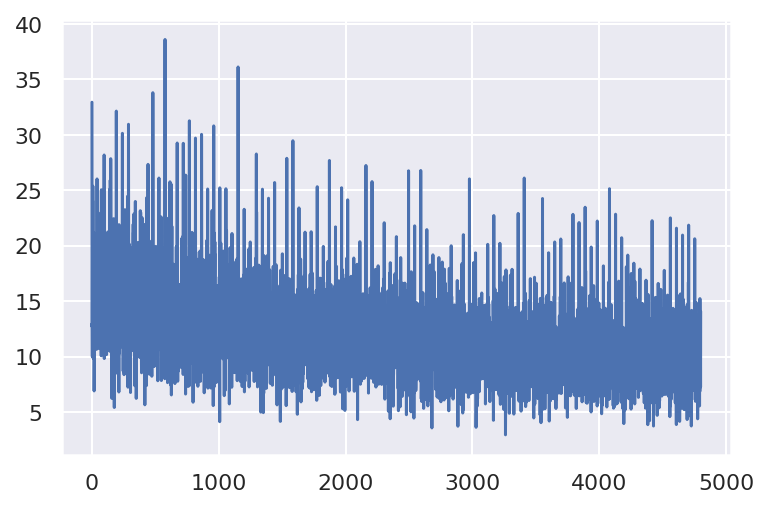

In [48]:
pd.Series(train_losses).plot()

In [49]:
tst_ds = RankerDataset(X_norm, X_cat, y_long)
tst_dl = DataLoader(trn_ds, batch_size=16, shuffle=False)

In [50]:
from project.ranker.neural_ranker import get_predictions

In [68]:
targets, preds = get_predictions(model, tst_dl)

In [69]:
from scipy.stats import rankdata

In [70]:
targets = np.reshape(targets, y.shape).astype(int)
preds = np.array([rankdata(x, method='ordinal') for x in \
                  np.reshape(preds, y.shape)]).astype(int)

In [73]:
y[10]

array([11,  5,  4, 12,  7,  8, 13,  9, 10,  3,  2,  1,  6])

In [74]:
targets[10]

array([11,  5,  4, 12,  7,  8, 13,  9, 10,  3,  2,  1,  6])

In [75]:
preds[10]

array([ 9,  1,  6, 11,  5, 12, 10,  4, 13,  7,  8,  2,  3])

In [76]:
from project.utils.metrics import evaluate_metric

In [77]:
evaluate_metric('spearman', targets, preds)

0.5504578754578754

In [79]:
evaluate_metric('mean_acc_loss', y_scores, preds)

0.0537788898473581